In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout, Input
import matplotlib.pyplot as plt
from util import plot_history
import util
import feature_builder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Cargo datasets

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Armo features con el feature_builder

In [3]:
#        encoding_type='one_hot',
# target_dimensions=5120,
#        text_type='tfidf',
#        clean_text=True
def prepare_for_cnn(df):
    processed = feature_builder.process_dataset(
        df,
        encoding_type='binary',
        #target_dimensions=2048,
        text_type='embeddings',
        use_spacy=True
    )
    to_numpy = processed.to_numpy()
    to_numpy = to_numpy.reshape(processed.shape[0], processed.shape[1], 1)
    return processed, to_numpy

In [4]:
%%time
processed, train = prepare_for_cnn(train_df)
train_target = train_df['target'].values

Percentage of words covered in the embeddings = 0.5961027457927369
Wall time: 1min 30s


In [5]:
processed

,invalid_location_character_count,location_is_place,c0,c1,c2,c3,c4,c5,c6,c7,...,text_embedding_290,text_embedding_291,text_embedding_292,text_embedding_293,text_embedding_294,text_embedding_295,text_embedding_296,text_embedding_297,text_embedding_298,text_embedding_299
0,0,0,0,0,0,0,0,0,0,0,...,-0.082031,0.089844,-0.106771,-0.059998,0.015706,0.030469,-0.046214,-0.095479,-0.046702,0.147787
1,0,0,0,0,0,0,0,0,0,0,...,-0.046265,-0.030090,-0.020996,0.193039,0.072998,0.037659,-0.125488,-0.050751,0.055298,0.122597
2,0,0,0,0,0,0,0,0,0,0,...,-0.116679,-0.049194,-0.145996,0.005137,0.108185,0.048630,-0.069520,0.034129,0.007436,-0.023438
3,0,0,0,0,0,0,0,0,0,0,...,0.171529,-0.051107,-0.022228,0.023926,0.264567,0.062831,-0.220500,0.032715,0.009521,-0.046468
4,0,0,0,0,0,0,0,0,0,0,...,0.064616,-0.163493,-0.065356,0.068441,0.042480,-0.028035,0.018890,-0.069858,0.038045,0.052456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,-0.143347,-0.014001,-0.056296,0.047510,0.016632,-0.073633,-0.051733,-0.062708,0.012656,-0.028198
7609,0,0,0,0,0,0,0,0,0,0,...,0.025770,-0.029290,-0.057761,0.026096,0.041463,-0.038730,-0.118056,-0.021094,0.054803,-0.006822
7610,0,0,0,0,0,0,0,0,0,0,...,0.083078,0.102155,-0.082136,0.059265,-0.101562,-0.013184,-0.208566,0.045846,0.091370,0.137486
7611,0,0,0,0,0,0,0,0,0,0,...,-0.003107,-0.039210,-0.069713,0.019941,-0.060690,0.006841,0.038869,-0.021599,-0.014613,-0.004369


In [6]:
X_train, X_pred, y_train, y_pred = train_test_split(train, train_target, test_size=0.33, random_state=42)

Creo el modelo y corro la CNN

In [7]:
def create_model(filters, kernel_sizes, pool_sizes, units, cnn_layers, dense_layers):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    for i in range(cnn_layers):
        model.add(Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], activation='relu'))
    model.add(MaxPooling1D(2))#pool_sizes[i]))

    model.add(Flatten())
    
    for i in range(dense_layers):
        model.add(Dense(units[i], activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])
    return model

In [8]:
filters=[32,32,64]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[64]
cnn_layers=3
dense_layers=1

In [10]:
#acc = 0.80 cleaner
filters=[128,128,128]
kernel_size=[3,4,5]
pool_sizes=[2,2,2]
units=[128*3]
cnn_layers=3
dense_layers=1

In [9]:
#acc = 0.8
filters=[128,128]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[32, 32]
cnn_layers=2
dense_layers=2

Epoch 1/15
319/319 [==============================] - 28s 87ms/step - loss: 0.6531 - accuracy: 0.6200 - val_loss: 0.5596 - val_accuracy: 0.7314
Epoch 2/15
319/319 [==============================] - 27s 84ms/step - loss: 0.5321 - accuracy: 0.7437 - val_loss: 0.4741 - val_accuracy: 0.7998
Epoch 3/15
319/319 [==============================] - 30s 93ms/step - loss: 0.4813 - accuracy: 0.7822 - val_loss: 0.4484 - val_accuracy: 0.8177
Epoch 4/15
319/319 [==============================] - 28s 87ms/step - loss: 0.4635 - accuracy: 0.7896 - val_loss: 0.4367 - val_accuracy: 0.8173
Epoch 5/15
319/319 [==============================] - 27s 84ms/step - loss: 0.4463 - accuracy: 0.7976 - val_loss: 0.4306 - val_accuracy: 0.8189
Epoch 6/15
319/319 [==============================] - 27s 84ms/step - loss: 0.4340 - accuracy: 0.8067 - val_loss: 0.4215 - val_accuracy: 0.8201
Epoch 7/15
319/319 [==============================] - 27s 83ms/step - loss: 0.4220 - accuracy: 0.8135 - val_loss: 0.4191 - val_accuracy:

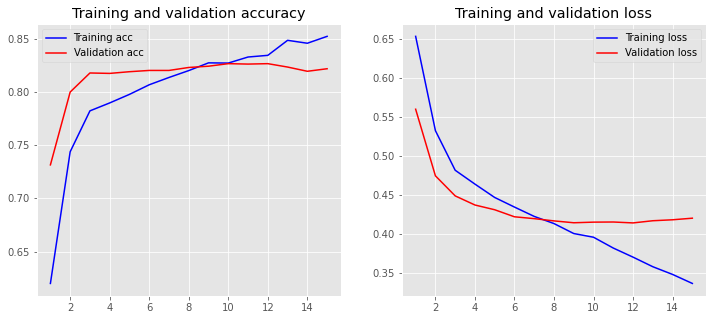

In [11]:
model = create_model(
    filters=filters,
    kernel_sizes=kernel_size,
    pool_sizes=pool_sizes,
    units=units,
    cnn_layers=cnn_layers,
    dense_layers=dense_layers
)
history = model.fit(X_train, y_train, epochs=15, shuffle=False, validation_data=(X_pred, y_pred), batch_size=16)
plot_history(history)

Calculemos el test para kaggle

In [12]:
prediction = model.predict_classes(X_pred)
f1 = f1_score(y_pred, [x[0] for x in prediction])
print(f'F1 Score: {f1}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
F1 Score: 0.7505330490405117


In [ ]:
ids = test_df['id']

processed, final_test = prepare_for_cnn(test_df)
prediction = model.predict_classes(final_test)

final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

In [ ]:
final_df['target'].value_counts()

In [ ]:
final_df.count()

In [ ]:
final_df.to_csv('cnn.csv')

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=False, epochs=25)

filters = [32,64,128,1024,10000]
kernel_size = [2,3,5]
units = [64,128]

param_grid = dict(filters=filters,kernel_size=kernel_size,units=units)# 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

#Run grid search
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
filters=[32,32,64]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[[64], [64, 64], [64, 32]]
cnn_layers=[1,2,3,4]
dense_layers=[1,2]